In [2]:
import os, sys, random
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
n_threads = os.cpu_count()
os.environ['OMPI_MCA_rmaps_base_oversubscribe'] = '1'
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
os.environ['NUMEXPR_MAX_self.n_threads'] = f'{n_threads}'
os.environ['NUMEXPR_NUM_self.n_threads'] = f'{n_threads}'
os.environ['OMP_THREAD_LIMIT'] = f'{n_threads}'
os.environ["OMP_NUM_self.n_threads"] = f'{n_threads}'
os.environ["OPENBLAS_NUM_self.n_threads"] = f'{n_threads}' 
os.environ["MKL_NUM_self.n_threads"] = f'{n_threads}'
os.environ["VECLIB_MAXIMUM_self.n_threads"] = f'{n_threads}'
os.environ["OMP_DYNAMIC"] = f'TRUE'
import numpy as np
import skmap_bindings as sb
import time
import matplotlib.pyplot as plt
from skmap.misc import TimeTracker
from statsmodels.stats.multitest import multipletests
import requests

def sb_arr(size):
    return np.empty(size, dtype=np.float32)
gdal_opts = {
 'GDAL_HTTP_VERSION': '1.0',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
}
x_size, y_size = (4004, 4004)
n_pix = x_size * y_size
x_off, y_off = (0,0)
bands_list = [1,]
years = range(2000,2023)
n_years = len(years)
no_data_out = 32767
compression_command = f"gdal_translate -a_nodata {no_data_out} -a_scale 0.0001 -co COMPRESS=deflate -co PREDICTOR=2 -co TILED=TRUE -co BLOCKXSIZE=2048 -co BLOCKYSIZE=2048"

p_values_th = 0.00005

start_tile = 10000
end_tile = 10001
with open("/mnt/slurm/jobs/wri_shv/tiles_svh.list", 'r') as file:
    tile_ids = [line.strip() for line in file]
tile_ids = tile_ids[start_tile:end_tile]
server_name='ripley'
base_dir = f'/mnt/{server_name}/global_soc/tmp_data'
os.makedirs(f'/mnt/{server_name}/global_soc', exist_ok=True)
os.makedirs(base_dir, exist_ok=True)


In [3]:
for tile_id in tile_ids:
    print(f'########## Tile {tile_id} ############')
    gaia_addrs = [f'http://192.168.49.{gaia_ip}:8333' for gaia_ip in range(30, 47)]
    tile_base_path = '{gaia_addr}/tmp-gpw/svh_prod_20250201/{tile_id}/gpw_short.veg.height_lgb_m_30m_s_{year}0101_{year}1231_go_epsg.4326_v20240809.tif'
    file_paths = [tile_base_path.format(tile_id=tile_id, year=year, gaia_addr=random.choice(gaia_addrs)) for year in years]
    
    urls_with_404 = []
    for url in file_paths:
        try:
            response = requests.head(url, timeout=10)
            if response.status_code == 404:
                urls_with_404.append(url)
        except requests.RequestException as e:
            print(f"Error checking URL {url}: {e}")
    for url in urls_with_404:
        print(url)
    assert len(urls_with_404) == 0, f"Tile {tile_id} has missing lafiles"
        
    read_data = sb_arr((n_years, n_pix))
    read_data_t = sb_arr(read_data.shape[::-1])
    with TimeTracker("Reading data", False):
        sb.readData(read_data, n_threads, file_paths, range(n_years), x_off, y_off, x_size, y_size, bands_list, gdal_opts, None, np.nan)
        sb.transposeArray(read_data, n_threads, read_data_t)

    with TimeTracker("Linear regression", False):
        time_samples = np.arange(n_years).astype(np.float32)
        slope = sb_arr((n_pix,))
        intercept = sb_arr((n_pix,))
        sb.linearRegression(read_data_t, n_threads, time_samples, intercept, slope)

    with TimeTracker("Computing p-values", False):
        p_values = sb_arr((n_pix,))
        sb.computeMannKendallPValues(read_data_t, n_threads, p_values)

    with TimeTracker("Preparing output data", False):
        out_data = sb_arr((3, n_pix))
        # _, pvals_corrected, _, _ = multipletests(p_values, alpha=p_values_th, method='fdr_bh')
        # trend = np.sign(slope)
        # trend[pvals_corrected > p_values_th] = 0.
        vec_mask = np.any(np.isnan(read_data), axis=0)
        out_data[0,:] = p_values.copy()*10000
        out_data[1,:] = slope.copy()*1000
        out_data[2,:] = slope.copy()*1000
        out_data[:,vec_mask] = np.nan
        out_data[2,:][p_values > p_values_th] = np.nan
        out_data = np.nan_to_num(out_data, nan = no_data_out)
        
        out_paths = ["gpw_short.veg.height_lgb.mk.pvalues_m_30m_s_20000101_20221231_go_epsg.4326_v20240809",
                     "gpw_short.veg.height_lgb.lr.trend_m_30m_s_20000101_20221231_go_epsg.4326_v20240809",
                     "gpw_short.veg.height_lgb.lr.trend.filt_m_30m_s_20000101_20221231_go_epsg.4326_v20240809"]
        
        out_s3 = [f'g{random.randint(1,15)}/tmp-gpw/svh-trends/{tile_id}' for _ in range(3)]

    with TimeTracker("Saving data", False):
        sb.writeInt16Data(out_data, n_threads, gdal_opts, file_paths, f'.', out_paths, range(3), x_off, y_off, x_size, y_size, no_data_out, compression_command, out_s3)


[22:42:36] Reading data: 0.51 secs
[22:42:37] Linear regression: 0.24 secs
[22:42:38] Computing p-values: 1.07 secs
[22:42:39] Preparing output data: 1.01 secs
[22:42:41] Saving data: 1.88 secs


In [2]:
slope_plt = vec_mask.reshape(x_size, y_size)
filtered_slope_plt = out_data[2,:].reshape(x_size, y_size)
slop_range = np.nanmax(np.abs(filtered_slope_plt))
plt_1, plt_2, plt_3, plt_4 = (0, x_size, 0, y_size)
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(slope_plt, cmap='PiYG')
plt.colorbar()
plt.title("Slope")
plt.subplot(222)
plt.imshow(filtered_slope_plt, cmap='RdYlGn', vmin=-slop_range, vmax=slop_range)
plt.xlim([plt_1-0.5, plt_2-0.5])
plt.ylim([plt_4-0.5, plt_3-0.5])
plt.colorbar()
plt.tight_layout()
plt.title("Filtered slope")
plt.show()




NameError: name 'vec_mask' is not defined

In [1]:
plt.figure(figsize=(30,10))
plt.hist(p_values, range=[0, 0.000005],bins=500)
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

NameError: name 'plt' is not defined

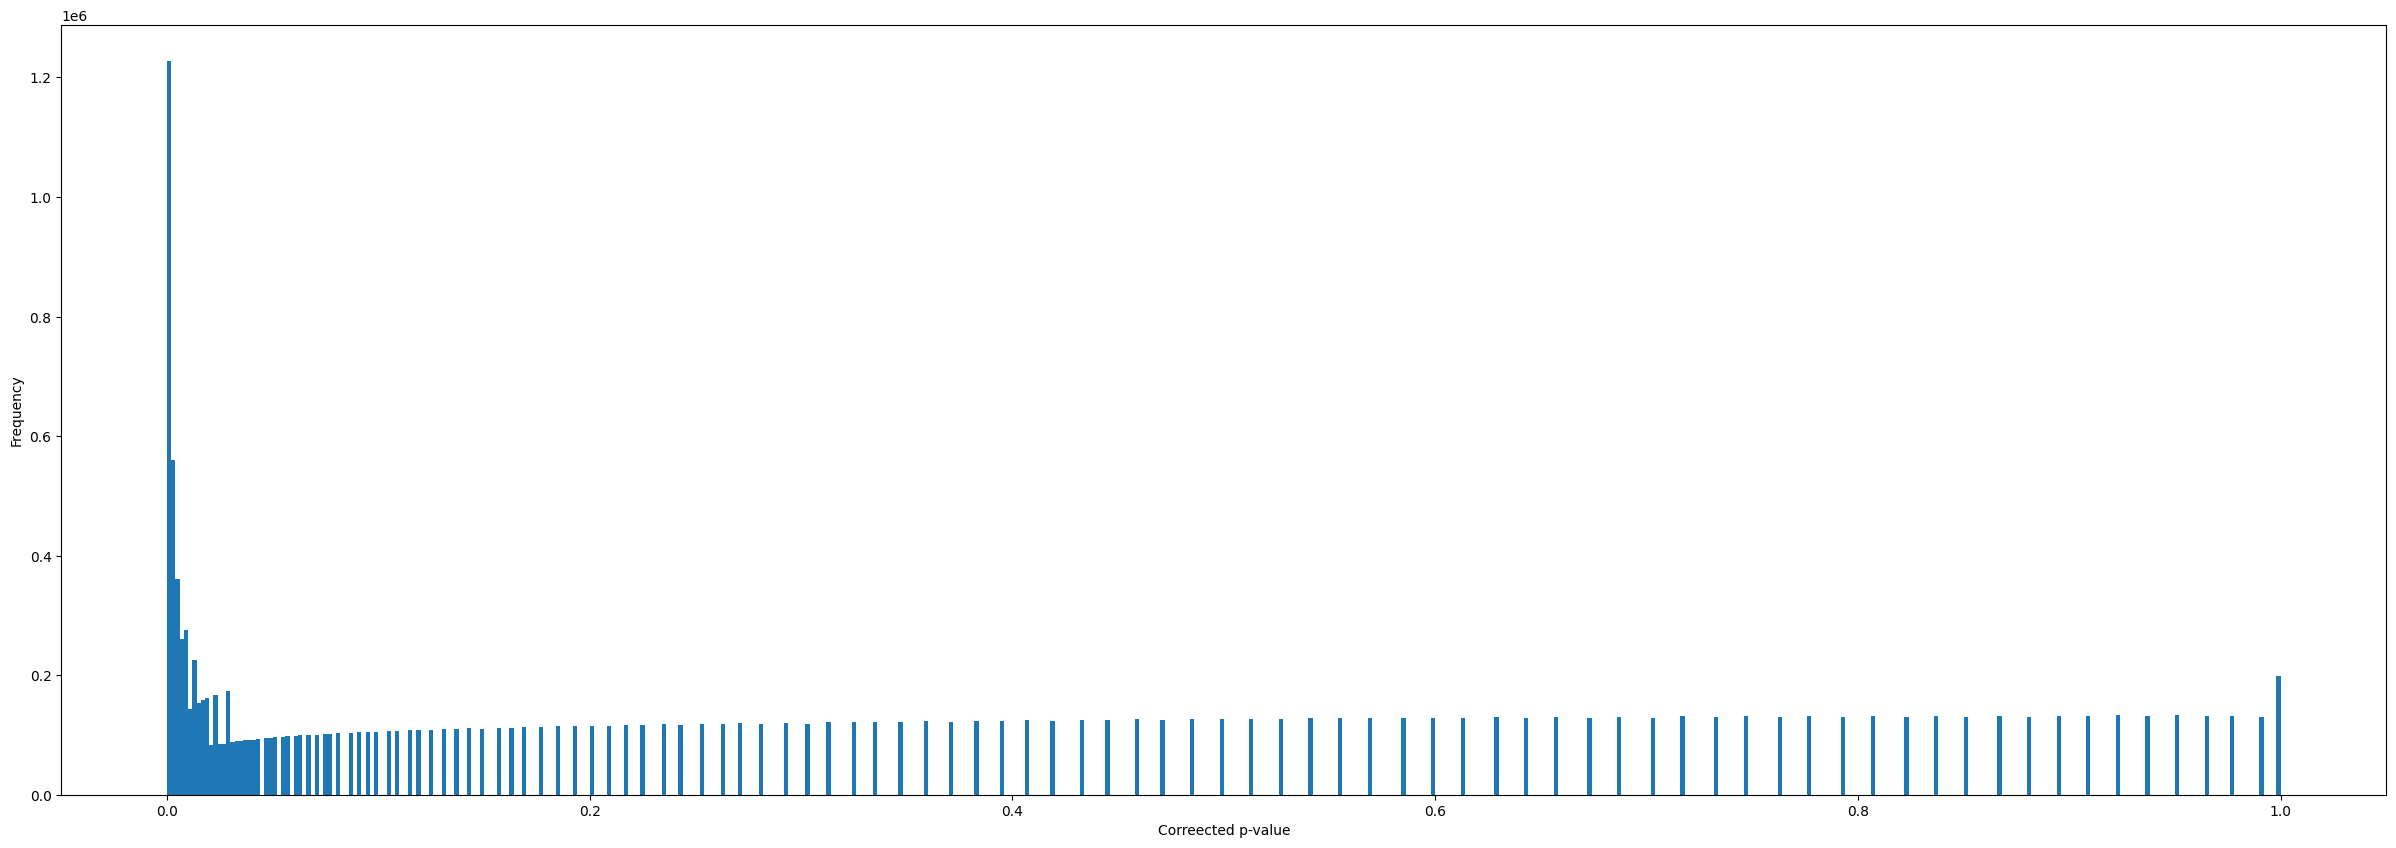

In [18]:
plt.figure(figsize=(30,10))
plt.hist(pvals_corrected, bins=500)
plt.xlabel('Correected p-value')
plt.ylabel('Frequency')
plt.show()